# Machine Learning to forecast Bitcoin price movements
# Part 4: Neural Network model and results discussion
In this notebook I will **apply a simple neural network to forecast prices and use a classifier to predict price movements**. For this I will be using `SKlearn`'s simple neural networks (`MLPRegressor` for price forecasting and `MLPClassifier` for classification of trading signals), and leave the use of PyTorch or TensorFlow for further studies outside the scope of this ML Capstone project. The contents of both models and the data feed into the models used can be found in the `sklearn/` folder.

As always, we will start by importing necessary libraries and setting up sagemaker session, role and S3 bucket parameters.

In [1]:
import pandas as pd
import boto3
import sagemaker

In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

### Data Preprocessing

We will start by grabbing the data features that we got from the PCA model and the original dataset's labels, to create adequate datasets to feed into the model. We also have to upload these contents into our S3 bucket, so we can feed in the model with our data.

In [3]:
pca_list = ['train','test']
store_list = ['train_ny','test_ny', 'test_y', 'train_y']
data = {}

for i in range(len(pca_list)):
    data[pca_list[i]] = pd.read_csv('pca/'+pca_list[i]+'.csv')
    data[pca_list[i]].drop(columns=['Unnamed: 0'], inplace=True)

    
for i in range(len(store_list)):
    data[store_list[i]] = pd.read_csv('data/'+store_list[i]+'.csv')
    data[store_list[i]].drop(columns=['Date'], inplace=True)

for x in data:
    print(data[x].tail())

      component_1  component_2  component_3  component_4  component_5  \
1835    -0.969989     0.277599     1.156140    -0.504672     0.093084   
1836    -1.021743    -0.387731     0.668942    -1.065100     0.019552   
1837    -1.014022    -0.547216     0.744433    -0.930917    -0.007225   
1838    -0.982989    -0.201810     0.978394    -0.659704     0.025067   
1839    -1.002244    -0.653113     0.796150    -0.846429    -0.014283   

      component_6  
1835     0.751546  
1836     0.723636  
1837     0.700540  
1838     0.725947  
1839     0.686890  
     component_1  component_2  component_3  component_4  component_5  \
865    -1.036036    -0.093710     1.092969    -0.883055    -0.580162   
866    -1.036391    -0.093952     1.088533    -0.877775    -0.580377   
867    -1.043998    -0.094252     1.107241    -0.897663    -0.571674   
868    -1.070880    -0.092534     1.132252    -0.923670    -0.555636   
869    -1.057992    -0.091633     1.120212    -0.912363    -0.566596   

     com

In [4]:
import os

# This is our local data directory
data_dir = './sklearn/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [5]:
# Forecasting/Regression
pd.concat([data['test_ny']['r_label'], data['test']], axis=1).to_csv(os.path.join(data_dir, 'r_test.csv'), header=False, index=False)
pd.concat([data['train_ny']['r_label'], data['train']], axis=1).to_csv(os.path.join(data_dir, 'r_train.csv'), header=False, index=False)

# Classification
pd.concat([data['test_y']['c_label'], data['test']], axis=1).to_csv(os.path.join(data_dir, 'c_test.csv'), header=False, index=False)
pd.concat([data['train_y']['c_label'], data['train']], axis=1).to_csv(os.path.join(data_dir, 'c_train.csv'), header=False, index=False)

In [6]:
# set prefix, a descriptive name for a directory  
prefix = 'sklearn'

# upload all data to S3
data = sagemaker_session.upload_data(
    path=data_dir, 
    bucket=bucket, 
    key_prefix=prefix)

# Price Predictor - Regression
We will first start by addressing the problem of forecasting Bitcoin prices. For this we will use the model described on the [`sklearn/r_train.py`](sklearn/r_train.py) file, where we define **SKLearn's MLPRegressor** model and hyperparameters. A copy of the file can be seen in the cell below.

In [7]:
!pygmentize sklearn/r_train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

# from sklearn.externals import joblib
import joblib

from sklearn.neural_network import MLPRegressor as nn

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the directories for training data and saving models; set automatically
    parser.add_argument('--output-data-dir', type=str, default=os.

### Model training

Now we instantiate an estimator and pass in our model and training dataset. The estimator takes the `r_train.py` file as an entry point for the model, the resources needed and SKLearn's framework version (we will use the latest one available in AWS Sagemaker, the 0.23-1).

In [8]:
from sagemaker.sklearn.estimator import SKLearn

r_estimator = SKLearn(
    role=role,
    entry_point="r_train.py",
    source_dir="sklearn",
    instance_count=1,
    instance_type="ml.c4.xlarge",
    framework_version='0.23-1')

In [9]:
%%time

# Train your estimator on S3 training data
r_estimator.fit({'train':data})

2020-12-31 11:51:27 Starting - Starting the training job...
2020-12-31 11:51:29 Starting - Launching requested ML instancesProfilerReport-1609415487: InProgress
......
2020-12-31 11:52:34 Starting - Preparing the instances for training...
2020-12-31 11:53:27 Downloading - Downloading input data...
2020-12-31 11:53:48 Training - Downloading the training image..2020-12-31 11:54:07,952 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-12-31 11:54:07,954 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-12-31 11:54:07,963 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-12-31 11:54:08,340 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-12-31 11:54:11,371 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-12-31 11:54:11,383 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus inst

### Deployment and testing
**To test our model we will first deploy an endpoint** so we can pass in our test data. After getting the results, we make a graph using `matplotlib` and see how our model performed.

In [10]:
%%time

# deploy your model to create a predictor
r_predictor = r_estimator.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

-----------------!CPU times: user 294 ms, sys: 11.3 ms, total: 305 ms
Wall time: 8min 32s


In [11]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "r_test.csv"), header=None, names=None)

# labels are in the first column
r_test_y = test_data.iloc[:,0]
r_test_x = test_data.iloc[:,1:]

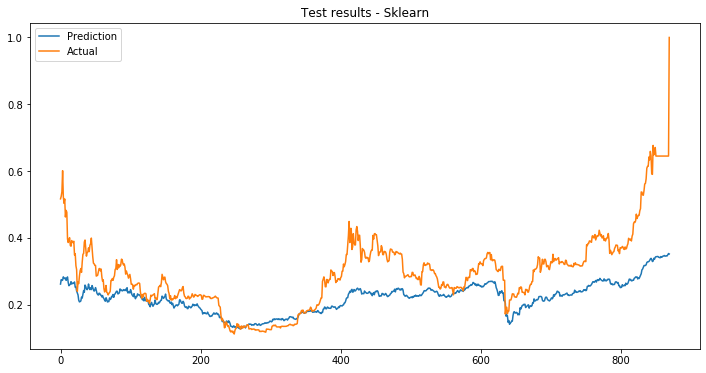

In [12]:
import matplotlib.pyplot as plt

r_predictions = r_predictor.predict(r_test_x)

plt.figure(figsize=(12,6))
plt.plot(r_predictions, label='Prediction')
plt.plot(r_test_y,label='Actual')
plt.title('Test results - Sklearn')
plt.legend()
plt.show()

In [13]:
import numpy as np

rmse = np.sqrt(np.square(r_predictions - r_test_y).mean())
print('RSME on test data: '+str(rmse))

RSME on test data: 0.10483776339089645


Now **this model actually performed way better with an RSME of 0.10** than the XGBoost on predicting prices. Not only it has a curve that resembles better what actually happened in real life (on the test dataset), but the average distance to the curve is considerably lower.

As always, we need to delete the endpoint created before going forward so we do not incur in additional costs.

In [14]:
# uncomment and fill in the line below!
r_predictor.delete_endpoint()

## Trading Signal Predictor - Classification

In order **to predict trading signals, we will use a multi-class classifier** that will tell us whether we should buy (2), sell (0) or stay out (1) of the Bitcoin market. In this case, we will use `Sklearn`'s `MLPClassifier` estimator. The model defined for this task can be found on the [`c_train.py` file](c_train.py).

Similar to the forecasting model used before, we start by instantiating an estimator, defining an entry point, necessary resources and an Sklean framework version, before passing in the training data.

In [15]:
from sagemaker.sklearn.estimator import SKLearn

c_estimator = SKLearn(
    role=role,
    entry_point="c_train.py",
    source_dir="sklearn",
    instance_count=1,
    instance_type="ml.c4.xlarge",
    framework_version='0.23-1')

In [16]:
%%time

# Train your estimator on S3 training data
c_estimator.fit({'train':data})

2020-12-31 12:03:13 Starting - Starting the training job...
2020-12-31 12:03:36 Starting - Launching requested ML instancesProfilerReport-1609416192: InProgress
......
2020-12-31 12:04:37 Starting - Preparing the instances for training......
2020-12-31 12:05:38 Downloading - Downloading input data...
2020-12-31 12:06:09 Training - Training image download completed. Training in progress..2020-12-31 12:06:10,150 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-12-31 12:06:10,152 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-12-31 12:06:10,171 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-12-31 12:06:10,579 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-12-31 12:06:16,815 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-12-31 12:06:16,826 sagemaker-training-toolkit INFO     No GPUs dete

## Deployment and Testing

For testing we will also deploy an estimator and pass in our test data afterwards. To evaluate results, we will take a look at the results and compute the accuracy score.

In [17]:
%%time

# deploy your model to create a predictor
c_predictor = c_estimator.deploy(initial_instance_count = 1, instance_type = "ml.t2.medium")

---------------!CPU times: user 263 ms, sys: 8.4 ms, total: 271 ms
Wall time: 7min 31s


In [18]:
import os

# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "c_test.csv"), header=None, names=None)

# labels are in the first column
c_test_y = test_data.iloc[:,0]
c_test_x = test_data.iloc[:,1:]

In [19]:
# generate predicted, class labels
c_predictions = c_predictor.predict(c_test_x)


# test that model generates the correct number of labels
assert len(c_predictions)==len(c_test_y), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [20]:
# compute the accuracy

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(c_test_y, c_predictions)

print(f'Accuracy: {accuracy}')

print('\nPredicted class labels: ')
print(c_predictions)
print('\nTrue class labels: ')
print(c_test_y.values)

Accuracy: 0.31494252873563217

Predicted class labels: 
[0. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 0. 0. 2. 2. 0. 2. 2. 2. 2. 2. 0. 2. 0.
 0. 0. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0.
 0. 2. 0. 2. 0. 2. 2. 2. 2. 2. 0. 2. 0. 0. 2. 0. 0. 2. 2. 0. 2. 0. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 2.
 0. 0. 0. 2. 2. 0. 0. 2. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 2. 2.
 2. 2. 2. 2. 0. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 2. 0. 2. 2. 2. 2. 2. 1. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 0. 1. 2. 1. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 1. 2. 1. 2. 1. 1. 1. 2. 1. 1. 2. 2.
 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1

After having a look at the results, we can see that **we are getting low accuracy results (31%), but nevertheless they seem more logical than XGBoost**, since it is actually classifying on the test dataset instead of recommending one label for it all. While this is not ideal, both results migh be signalling us that the models and hyperparameters taken before were not the issue, and the problem might be on the feedin data set, which might contain a certain bias. Considering that Bitcoin has had a price surge of >10.000% in the last years, and during our data preprocessing we saw that it is more likely that the price goes up than down, it is not a surprise that the model ended up being somewhat biased for a buy signal.

As always, we shouldn't forget to delete the deployed endpoints to avoid incurring in additional costs.

In [21]:
c_predictor.delete_endpoint()

# Conclusions

- With the PCA model, we could **reduce the dimensionality of the original dataset from 27 to 6 features**, preserving more than 90% of the variance.
- When forecasting Bitcoin prices, **sklearn's neural network performed better than XGBoost**, both visually (similarity of the curve) and also on the root mean square error on the testing data set (0.10 vs 0.15).
- When predicting trading signals using multi-class classification, **both models resulted in low accuracy (31-60%)**. In case of the XGBoost it returns buy signals throughout the whole test data set, while the neural network is more biased to the buy signal. This might be due to a natural bias of the feed-in data set, since in historical data Bitcoin shows a higher tendency to have positive daily returns, plus a cumulated price surge of >10.000% over the last 10 years. In future studies, shuffling the dataset before training and validating could maybe improve results.